# Tutorial em Tensorflow: Regressão Linear

Nesse tutorial vamos montar um modelo de regressão linear usando a biblioteca [Tensorflow](https://www.tensorflow.org/).

In [1]:
# Todos as bibliotecas que vamos usar
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
%matplotlib inline

Vamos usar um dataset bem simples: [Fire and Theft in Chicago](http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html)

As obervações são pares $(X,Y)$ em que

- $X =$ incêncios por 1000 moradías
- $Y =$ roubos por 1000 habitantes

referentes a cidade de Chicago.

In [2]:
# Podemos olhar o começo dessa tabela
df = pd.read_excel('data/fire_theft.xls')
df.head()

,X,Y
0,6.2,29
1,9.5,44
2,10.5,36
3,7.7,37
4,8.6,53


In [3]:
# E também podemos ver algumas estatísticas descritivas básicas
df.describe()

,X,Y
count,42.000000,42.000000
mean,12.692857,33.666667
std,9.667683,23.040438
min,2.000000,4.000000
25%,5.625000,22.000000
50%,10.500000,31.000000
75%,17.175000,39.750000
max,39.700000,147.000000


In [4]:
#transformando o dataset numa matrix
data = df.as_matrix()
data = data.astype('float32')

Antes de montar o modelo vamos definir todos os **Hyper parametros**

In [5]:
num_samples = data.shape[0]
learning_rate=0.001
num_epochs=101
show_epoch=10

## Falar rápido sobre Grafo e sessão no tf

In [6]:
session = tf.InteractiveSession()

# criando os placeholders para o par (X, Y)
tf_number_fire = tf.placeholder(tf.float32, shape=[], name="X")
tf_number_theft = tf.placeholder(tf.float32, shape=[], name="Y")

# criando os placeholders para o learning rate
tf_learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")



# definindo os pesos do modelo. Ambos são inicializados com 0.
with tf.name_scope("Weights"):
    tf_weight = tf.get_variable("w", dtype=tf.float32, initializer=0.)
    tf_bias = tf.get_variable("b", dtype=tf.float32, initializer=0.)

# criando a predição do modelo: prediction = w*x +b
with tf.name_scope("linear-model"):
            tf_prediction = (tf_weight * tf_number_fire) + tf_bias

# Definindo a função de custo como
# o erro quadrático médio: (preiction -Y)^2
with tf.name_scope("loss"):
    tf_loss = tf.square(tf_prediction - tf_number_theft)
    
    
#Definindo o otimizador para fazer o SGD
with tf.name_scope("optimizer"):
    tf_opt = tf.train.GradientDescentOptimizer(tf_learning_rate)
    tf_optimizer = tf_opt.minimize(tf_loss)


# Chamando a classe `FileWriter` para ver o grafo de computação     
tf_writer = tf.summary.FileWriter("LRgraph", session.graph)
tf_writer.close()

Falar algo sobre o [Tensorboard](https://www.tensorflow.org/get_started/graph_viz)

In [7]:
#!tensorboard  --logdir=LRgraph

In [8]:
num_samples = data.shape[0]
learning_rate=0.001
num_epochs=101
show_epoch=10

In [9]:
def run_training(learning_rate, num_epochs, show_epoch, num_samples, verbose=True):
    if verbose:
        print('Start training\n')
    session.run(tf.global_variables_initializer())
    step = 0
    for i in range(num_epochs):
        total_loss = 0
        for x, y in data:
            feed_dict = {tf_number_fire: x,
                        tf_number_theft: y,
                        tf_learning_rate: learning_rate}
            _,loss,w,b = session.run([tf_optimizer,tf_loss, tf_weight, tf_bias], feed_dict=feed_dict)
            total_loss += loss
        if verbose:
            if i % show_epoch == 0:
                print("\nEpoch {0}: {1}".format(i, total_loss/num_samples))
    return total_loss, w, b


In [10]:
loss, w, b = run_training(learning_rate, num_epochs, show_epoch, num_samples)
print(loss, w, b)

Start training


Epoch 0: 2069.6319333978354

Epoch 10: 1924.5930823644712

Epoch 20: 1773.1024853109072

Epoch 30: 1666.1935385839038

Epoch 40: 1589.668056331575

Epoch 50: 1534.211797797609

Epoch 60: 1493.600210891061

Epoch 70: 1463.5996563179153

Epoch 80: 1441.2782130186733

Epoch 90: 1424.5748210840281

Epoch 100: 1412.0180716720365
59304.7590102 1.71577 15.8192


In [11]:
def r_squared(data, w, b):
    """
    Calculate the R^2 value
    
    :type data: np array
    :type w: float
    :type b: float
    :rtype: float
    """
    X, Y = data.T[0], data.T[1]
    Y_hat = X * w + b
    Y_mean = np.mean(Y) 
    sstot = np.sum(np.square(Y - Y_mean))
    ssreg = np.sum(np.square(Y_hat - Y_mean))
    return 1 - (ssreg/sstot)

def plot_line(data, w, b, title, r_squared):
    """
    Plot the regression line
    
    :type data: np array
    :type w: float
    :type b: float
    :type title: str
    :type r_squared: float
    """
    X, Y = data.T[0], data.T[1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(X, Y, 'bo', label='Real data')
    plt.plot(X, X * w + b, 'r', label='Predicted data')
    plt.title(title)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.2)
    t = ax.text(20, 135, "$R^2 ={:.4f}$".format(r_squared), size=15, bbox=bbox_props)
    plt.legend()
    plt.show()

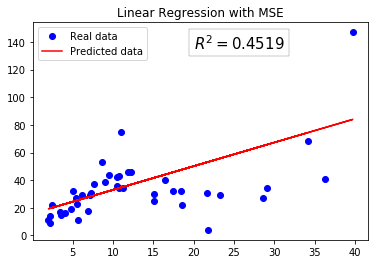

In [12]:
r2 = r_squared(data,w,b)
plot_line(data, w, b, "Linear Regression with MSE", r2)

In [13]:
def lr_tunning(data, number_of_exp=10):
    """
    Function that returns the best weights after training the model
    with some random values for the learning rate. 
    
    :type data: np array
    :type number_of_exp: int
    :type clean: boolean
    :type huber: boolean
    :rtype w: float
    :rtype b: float
    """
    LR = np.random.random_sample([number_of_exp])/1000
    LR.sort()
    best_loss = float('inf')
    for i, lr in enumerate(LR):
        header1 = "\n=============== ({0} of {1}) ===============\n".format(i + 1, number_of_exp)
        header2 = "  learning rate = {}".format(lr)
        header3 = "\n=========================================\n"
        print(header1 + header2 + header3)
        current_loss, current_w, current_b = run_training(learning_rate,
                                                          num_epochs,
                                                          show_epoch,
                                                          num_samples,
                                                          verbose=False)
        if current_loss < best_loss:
            best_loss, best_lr = current_loss, lr
            w, b = current_w, current_b
    print("\nbest learning rate = {0}\nbest loss = {1}".format(best_lr,
                                                               best_loss/num_samples))
    return w, b

In [14]:
lr_tunning(data, number_of_exp=10)


=============== (1 of 10) ===============
  learning rate = 0.0001535400057224784


=============== (2 of 10) ===============
  learning rate = 0.0001714106282424076


=============== (3 of 10) ===============
  learning rate = 0.00036300908379666895


=============== (4 of 10) ===============
  learning rate = 0.0004794753707864501


=============== (5 of 10) ===============
  learning rate = 0.0005004505892962977


=============== (6 of 10) ===============
  learning rate = 0.0005252250956162497


=============== (7 of 10) ===============
  learning rate = 0.0005842243696452339


=============== (8 of 10) ===============
  learning rate = 0.0006112882949962431


=============== (9 of 10) ===============
  learning rate = 0.0007580208297534394


=============== (10 of 10) ===============
  learning rate = 0.0008047211436239748


best learning rate = 0.0001535400057224784
best loss = 1412.0180716720365


(1.7157741, 15.819244)